I will explore how we can use maximum entropy prior corrections from [Handley & Millea (2019)](http://arxiv.org/abs/1804.08143) to impose flat priors on galaxy properties **while we use Dirichlet priors on the SFH basis coefficients $\{\beta_i\}$**. We want to impose Dirichlet priors on these coefficients because that's more physically motivated. 

In [1]:
import os, h5py
import numpy as np 
import corner as DFM 
import wquantiles as wq
from scipy.stats import gaussian_kde as gkde
# --- gpc_mc --- 
from gqp_mc import data as Data 
from gqp_mc import fitters as Fitters

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

Sample $\{b_i\}$ from Dirichlet prior using the warped manifold transformation

In [3]:
n_sample = 10000
bp1 = np.random.uniform(size=n_sample)
bp2 = np.random.uniform(size=n_sample)
bp3 = np.random.uniform(size=n_sample)
bp4 = np.random.uniform(size=n_sample)

ispec = Fitters.iSpeculator()

# warped manifold transform
beta_arr = ispec._transform_to_SFH_basis(np.array([bp1, bp2, bp3, bp4]).T)
# betas
b1, b2, b3, b4 = beta_arr.T

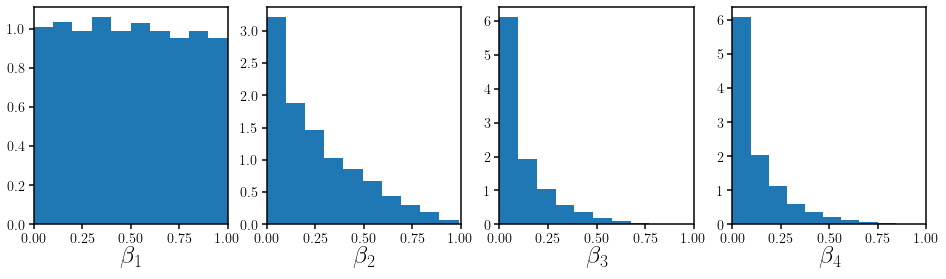

In [4]:
fig = plt.figure(figsize=(16,4))
for i, _y in enumerate([b1, b2, b3, b4]): 
    sub = fig.add_subplot(1,4,i+1)
    sub.hist(_y, density=True)
    sub.set_xlim(0., 1)
    sub.set_xlabel(r'$\beta_{%i}$' % (i+1), fontsize=25)

Now lets calculate the derived properties ${\rm SSFR}_{100Myr}$ and ${\rm SSFR}_{1Gyr}$ from the sampled $\{\beta_i\}$

In [5]:
ssfr_1gyr = ispec.get_SFR(np.array([np.ones(len(b1)), b1, b2, b3, b4]), 0.1, dt=1.)
ssfr_100myr = ispec.get_SFR(np.array([np.ones(len(b1)), b1, b2, b3, b4]), 0.1, dt=0.1)

logssfr_1gyr = np.log10(ssfr_1gyr)
logssfr_100myr = np.log10(ssfr_100myr)

Here's what $P( {\rm SSFR}\,|\,p_{\rm Dirichlet}(\beta_i))$ look like

(0.0, 3e-09)

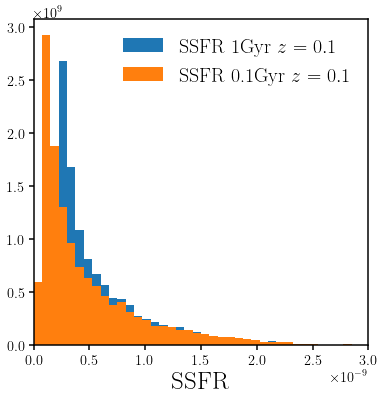

In [6]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.hist(ssfr_1gyr, range=[0, 3e-9], bins=40, density=True, label='SSFR 1Gyr $z=0.1$')
sub.hist(ssfr_100myr, range=[0, 3e-9], bins=40, density=True, label='SSFR 0.1Gyr $z=0.1$')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'${\rm SSFR}$', fontsize=25)
sub.set_xlim(0, 3e-9)

Now lets fits a KDE to $p({\rm SSFR})$

In [7]:
kde_ssfr1gyr = gkde(ssfr_1gyr * 1e9)

In [8]:
kde_sample = kde_ssfr1gyr.resample(1000).flatten()

(0.0, 3e-09)

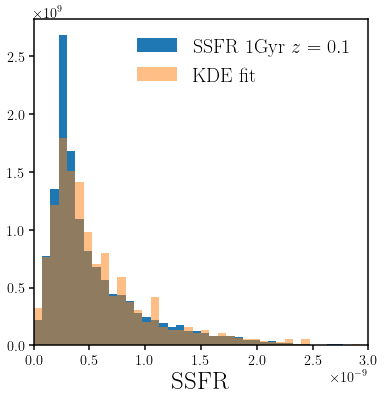

In [9]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.hist(ssfr_1gyr,  range=[0, 3e-9], bins=40, density=True, label='SSFR 1Gyr $z=0.1$')
sub.hist(kde_sample.flatten() / 1e9, range=[0, 3e-9], bins=40, density=True, alpha=0.5, label='KDE fit')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'${\rm SSFR}$', fontsize=25)
sub.set_xlim(0, 3e-9)

KDE is a good enough fit. So lets calculate the correction factor for the max-entropy priors: 

$$\frac{1}{P( {\rm SSFR}\,|\,p_{\rm Dirichlet}(\beta_i))}$$

In [10]:
w_ssfr1gyr = 1./kde_ssfr1gyr.pdf(ssfr_1gyr * 1e9)

In [11]:
kde_ssfr100myr = gkde(ssfr_100myr * 1e9)
w_ssfr100myr = 1./kde_ssfr100myr.pdf(ssfr_100myr * 1e9)

(0.0, 3e-09)

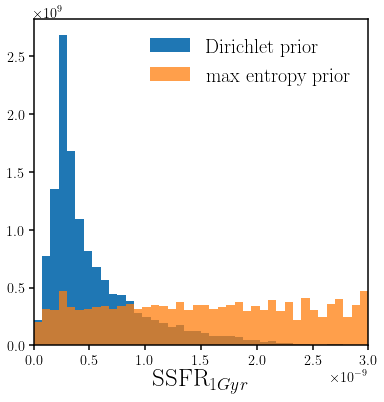

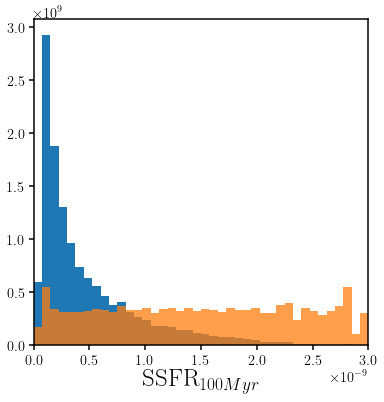

In [12]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.hist(ssfr_1gyr, range=[0, 3e-9], bins=40, density=True, label='Dirichlet prior')
sub.hist(ssfr_1gyr, weights=w_ssfr1gyr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max entropy prior')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
sub.set_xlim(0, 3e-9)

fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.hist(ssfr_100myr, range=[0, 3e-9], bins=40, density=True)
sub.hist(ssfr_100myr, weights=w_ssfr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75)
sub.set_xlabel(r'${\rm SSFR}_{100Myr}$', fontsize=25)
sub.set_xlim(0, 3e-9)

Works like a charm. Lets try the same but for $\log {\rm SSFR}_{1Gyr}$, $\log {\rm SSFR}_{100Mr}$

(-11.0, -8.0)

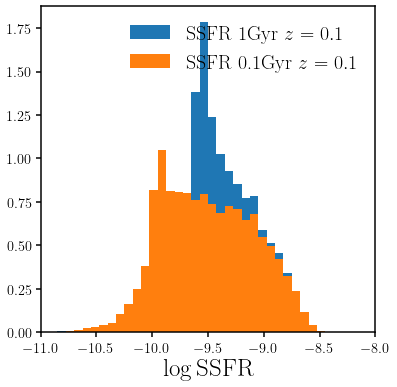

In [13]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.hist(logssfr_1gyr, range=[-11, -8], bins=40, density=True, label='SSFR 1Gyr $z=0.1$')
sub.hist(logssfr_100myr, range=[-11, -8], bins=40,density=True, color='C1', label='SSFR 0.1Gyr $z=0.1$')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'$\log {\rm SSFR}$', fontsize=25)
sub.set_xlim(-11, -8)

In [14]:
kde_logssfr1gyr = gkde(logssfr_1gyr)
w_logssfr1gyr = 1./kde_logssfr1gyr.pdf(logssfr_1gyr)

kde_logssfr100myr = gkde(logssfr_100myr)
w_logssfr100myr = 1./kde_logssfr100myr.pdf(logssfr_100myr)

(-11.0, -8.0)

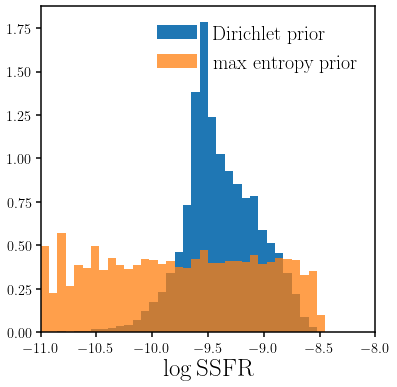

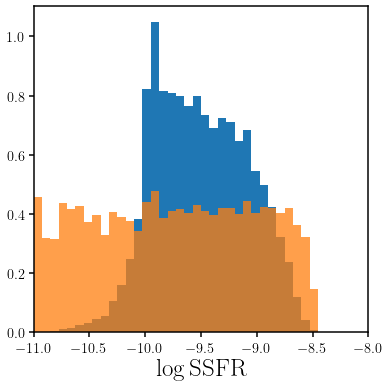

In [15]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.hist(logssfr_1gyr, range=[-11, -8], bins=40, density=True, label='Dirichlet prior')
sub.hist(logssfr_1gyr, weights=w_logssfr1gyr, range=[-11, -8], bins=40,density=True, color='C1', alpha=0.75, label='max entropy prior')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'$\log {\rm SSFR}$', fontsize=25)
sub.set_xlim(-11, -8)

fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.hist(logssfr_100myr, range=[-11, -8], bins=40, density=True)
sub.hist(logssfr_100myr, weights=w_logssfr100myr, range=[-11, -8], bins=40,density=True, color='C1', alpha=0.75)
sub.set_xlabel(r'$\log {\rm SSFR}$', fontsize=25)
sub.set_xlim(-11, -8)

# uniform priors on multiple derived properties
So far, I"ve used the maximum entropy priors to impose uniform priors on a *single* derived property. In principle, we should be able to impose uniform priors on multiple properties (e.g. 100Myr SFR *and* 1Gyr SFR). Lets test this below

In [16]:
import corner as DFM
from sklearn.mixture import GaussianMixture as GMix

First lets see what the joint prior $p({\rm SFR}_{100Myr}, {\rm SFR}_{1Gyr})$ looks like

In [125]:
n_sample = 100000
bp1 = np.random.uniform(size=n_sample)
bp2 = np.random.uniform(size=n_sample)
bp3 = np.random.uniform(size=n_sample)
bp4 = np.random.uniform(size=n_sample)

ispec = Fitters.iSpeculator()

# warped manifold transform
beta_arr = ispec._transform_to_SFH_basis(np.array([bp1, bp2, bp3, bp4]).T)
# betas
b1, b2, b3, b4 = beta_arr.T

ssfr_1gyr = ispec.get_SFR(np.array([np.ones(len(b1)), b1, b2, b3, b4]), 0.1, dt=1.)
ssfr_100myr = ispec.get_SFR(np.array([np.ones(len(b1)), b1, b2, b3, b4]), 0.1, dt=0.1)

logssfr_1gyr = np.log10(ssfr_1gyr)
logssfr_100myr = np.log10(ssfr_100myr)

(0.0, 5e-10)

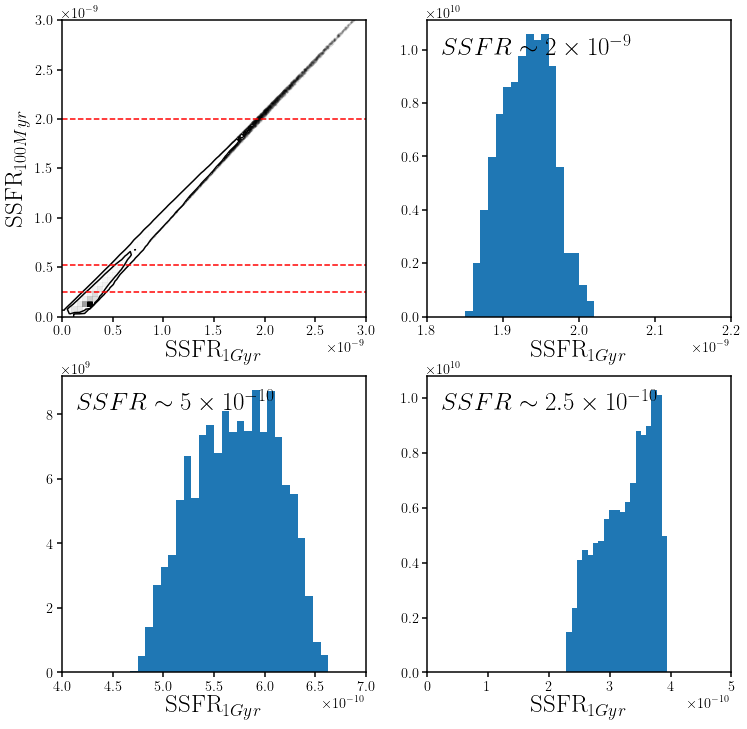

In [148]:
fig = plt.figure(figsize=(12,12))
sub = fig.add_subplot(221)

DFM.hist2d(ssfr_1gyr, ssfr_100myr, color='k', levels=[0.68, 0.95], 
        range=[[0., 3e-9], [0., 3e-9]], bins=60,  
        plot_datapoints=True, fill_contours=False, plot_density=True, linewidth=0.5, 
        ax=sub) 
sub.plot([0., 3e-9], [2e-9, 2e-9], c='r', ls='--')
sub.plot([0., 3e-9], [0.525e-9, 0.525e-9], c='r', ls='--')
sub.plot([0., 3e-9], [0.25e-9, 0.25e-9], c='r', ls='--')

sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
sub.set_xlim(0, 3e-9)
sub.set_ylabel(r'${\rm SSFR}_{100Myr}$', fontsize=25)
sub.set_ylim(0, 3e-9)

sub = fig.add_subplot(222)
sub.hist(ssfr_1gyr[(ssfr_100myr > 1.95e-9) & (ssfr_100myr < 2.05e-9)], range=(1.8e-9, 2.2e-9), bins=40, density=True)
sub.text(0.05, 0.95, r'$SSFR \sim 2\times10^{-9}$', 
         transform=sub.transAxes, ha='left', va='top', fontsize=25)
sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
sub.set_xlim(1.8e-9, 2.2e-9)

sub = fig.add_subplot(223)
sub.hist(ssfr_1gyr[(ssfr_100myr > 0.5e-9) & (ssfr_100myr < 0.55e-9)], range=(0.4e-9, 0.7e-9), bins=40, density=True)
sub.text(0.05, 0.95, r'$SSFR \sim 5\times10^{-10}$', 
         transform=sub.transAxes, ha='left', va='top', fontsize=25)
sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
sub.set_xlim(0.4e-9, 0.7e-9)

sub = fig.add_subplot(224)
sub.hist(ssfr_1gyr[(ssfr_100myr > 0.245e-9) & (ssfr_100myr < 0.255e-9)], range=(0.15e-9, 0.5e-9), bins=40, density=True)
sub.text(0.05, 0.95, r'$SSFR \sim 2.5\times10^{-10}$', 
         transform=sub.transAxes, ha='left', va='top', fontsize=25)
sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
sub.set_xlim(0., 0.5e-9)

In [129]:
def bestfit_gmm(x, max_comp=5): 
    # fit GMMs with a range of components 
    ncomps = range(1, max_comp+1)
    gmms, bics = [], []  
    for i_n, n in enumerate(ncomps): 
        gmm = GMix(n_components=n)
        gmm.fit(x)
        bics.append(gmm.bic(x)) # bayesian information criteria
        gmms.append(gmm)

    # components with the lowest BIC (preferred)
    i_best = np.array(bics).argmin()
    print(ncomps[i_best]) # number of components of the best-fit
    gbest = gmms[i_best] # best fit GMM 
    return gbest

Lets fit a KDE and GMM to the distribution above and check that it looks reasonable

In [140]:
kde_ssfr1gyr100myr = gkde(np.array([ssfr_1gyr, ssfr_100myr]) * 1e9)
gmm_ssfr1gyr100myr = bestfit_gmm(np.array([ssfr_1gyr, ssfr_100myr]).T * 1e9, max_comp=10)

7


In [141]:
_kde_samples = kde_ssfr1gyr100myr.resample(10000)
_kde_samples *= 1e-9
_gmm_samples, _ = gmm_ssfr1gyr100myr.sample(10000)
_gmm_samples *= 1e-9

(0.0, 3e-09)

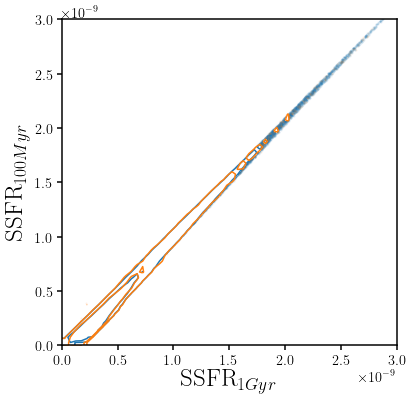

In [142]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)

DFM.hist2d(ssfr_1gyr, ssfr_100myr, color='C0', levels=[0.68, 0.95], 
        range=[[0., 3e-9], [0., 3e-9]], bins=60,
        plot_datapoints=True, fill_contours=False, plot_density=False, linewidth=0.5, 
        ax=sub) 

DFM.hist2d(_kde_samples[0,:], _kde_samples[1,:], color='C1', levels=[0.68, 0.95], 
        range=[[0., 3e-9], [0., 3e-9]], bins=60, 
        plot_datapoints=True, fill_contours=False, plot_density=False, linewidth=0.5, 
        ax=sub) 


DFM.hist2d(_gmm_samples[0,:], _gmm_samples[1,:], color='C1', levels=[0.68, 0.95], 
        range=[[0., 3e-9], [0., 3e-9]], bins=60, 
        plot_datapoints=True, fill_contours=False, plot_density=False, linewidth=0.5, 
        ax=sub) 
sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
sub.set_xlim(0, 3e-9)
sub.set_ylabel(r'${\rm SSFR}_{100Myr}$', fontsize=25)
sub.set_ylim(0, 3e-9)

Doesn't look too bad. Maybe things fall apart at high SSFRs. Lets see if the maximum entropy priors using the factor

$$\frac{1}{P({\rm SSFR}_{1Gyr}, {\rm SSFR}_{100Myr}\,|\, p_{\rm Dirichlet}(\beta))}$$

imposes uniform priors on both ${\rm SSFR}_{100Myr}$ and ${\rm SSFR}_{1Gyr}$

In [143]:
w_kde_ssfr1gyr100myr = 1./kde_ssfr1gyr100myr.pdf(np.array([ssfr_1gyr * 1e9, ssfr_100myr * 1e9]))
w_gmm_ssfr1gyr100myr = 1./np.exp(gmm_ssfr1gyr100myr.score_samples(np.array([ssfr_1gyr * 1e9, ssfr_100myr * 1e9]).T))

In [144]:
print(w_kde_ssfr1gyr100myr[:5])
print(w_gmm_ssfr1gyr100myr[:5])

[0.23570972 0.13749699 0.57056753 0.27741204 0.08695593]
[0.45225    0.04335894 0.86999196 0.44649337 0.07457427]


(0.0, 3e-09)

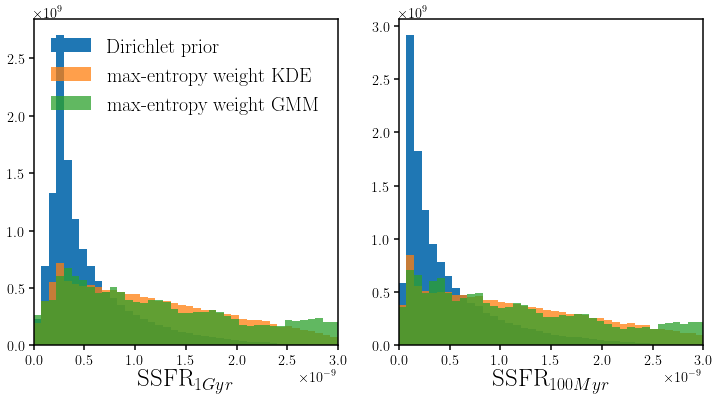

In [145]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.hist(ssfr_1gyr, range=[0, 3e-9], bins=40, density=True, label='Dirichlet prior')
sub.hist(ssfr_1gyr, weights=w_kde_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight KDE')
sub.hist(ssfr_1gyr, weights=w_gmm_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight GMM')

sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
sub.set_xlim(0, 3e-9)

sub = fig.add_subplot(122)
sub.hist(ssfr_100myr, range=[0, 3e-9], bins=40, density=True, label='Dirichlet prior')
sub.hist(ssfr_100myr, weights=w_kde_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight')
sub.hist(ssfr_100myr, weights=w_gmm_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight')
#sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'${\rm SSFR}_{100Myr}$', fontsize=25)
sub.set_xlim(0, 3e-9)

Better --- but not great. Could this be due to the KDE breaking down at the ${\rm SSFR} = 0$ cut off? Lets try for $\log {\rm SSFR}$

(-11.0, -8.0)

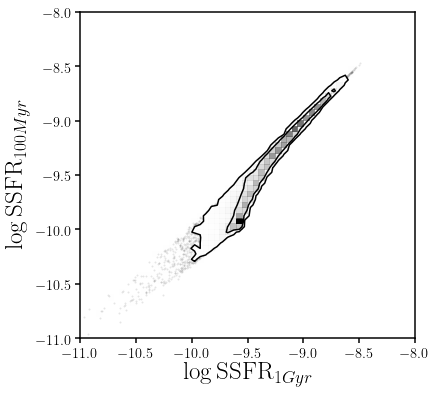

In [118]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)

DFM.hist2d(logssfr_1gyr, logssfr_100myr, color='k', levels=[0.68, 0.95], 
        range=[[-11., -8], [-11., -8]], bins=60, 
        plot_datapoints=True, fill_contours=False, plot_density=True, linewidth=0.5, 
        ax=sub) 
sub.set_xlabel(r'$\log{\rm SSFR}_{1Gyr}$', fontsize=25)
sub.set_xlim(-11, -8)
sub.set_ylabel(r'$\log{\rm SSFR}_{100Myr}$', fontsize=25)
sub.set_ylim(-11, -8)

In [112]:
kde_logssfr1gyr100myr = gkde(np.array([logssfr_1gyr, logssfr_100myr]))
gmm_logssfr1gyr100myr = bestfit_gmm(np.array([logssfr_1gyr, logssfr_100myr]).T, max_comp=50)

23


In [113]:
_kde_sample = kde_logssfr1gyr100myr.resample(10000)
_gmm_sample, _ = gmm_logssfr1gyr100myr.sample(10000)

(-11.0, -8.0)

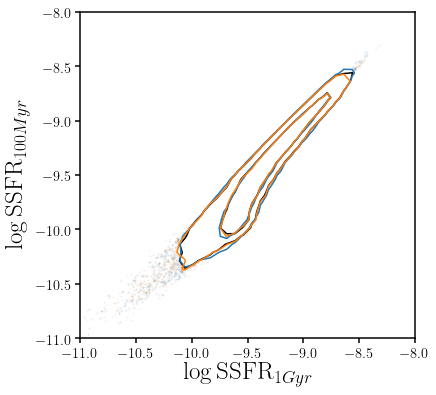

In [114]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)

DFM.hist2d(logssfr_1gyr, logssfr_100myr, color='k', levels=[0.68, 0.95], 
        range=[[-11., -8], [-11., -8]], bins=40, smooth=0.5,
        plot_datapoints=True, fill_contours=False, plot_density=False, linewidth=0.5, 
        ax=sub) 

DFM.hist2d(_kde_sample[0,:], _kde_sample[1,:], color='C0', levels=[0.68, 0.95], 
        range=[[-11., -8], [-11., -8]], bins=40, smooth=0.5, 
        plot_datapoints=True, fill_contours=False, plot_density=False, linewidth=0.5, 
        ax=sub) 

DFM.hist2d(_gmm_sample[:,0], _gmm_sample[:,1], color='C1', levels=[0.68, 0.95], 
        range=[[-11., -8], [-11., -8]], bins=40, smooth=0.5, 
        plot_datapoints=True, fill_contours=False, plot_density=False, linewidth=0.5, 
        ax=sub) 

sub.set_xlabel(r'$\log{\rm SSFR}_{1Gyr}$', fontsize=25)
sub.set_xlim(-11, -8)
sub.set_ylabel(r'$\log{\rm SSFR}_{100Myr}$', fontsize=25)
sub.set_ylim(-11, -8)

In [115]:
w_kde_logssfr1gyr100myr = 1./kde_logssfr1gyr100myr.pdf(np.array([logssfr_1gyr, logssfr_100myr]))
w_gmm_logssfr1gyr100myr = 1./np.exp(gmm_logssfr1gyr100myr.score_samples(np.array([logssfr_1gyr, logssfr_100myr]).T))

In [116]:
print(w_kde_logssfr1gyr100myr[:-5])
print(w_gmm_logssfr1gyr100myr[:-5])

[0.28835558 0.25456535 0.2414329  ... 0.15656195 0.17870422 0.24821176]
[0.42096182 0.22897976 0.25926846 ... 0.14203403 0.26716474 0.03756368]


(-11.0, -8.0)

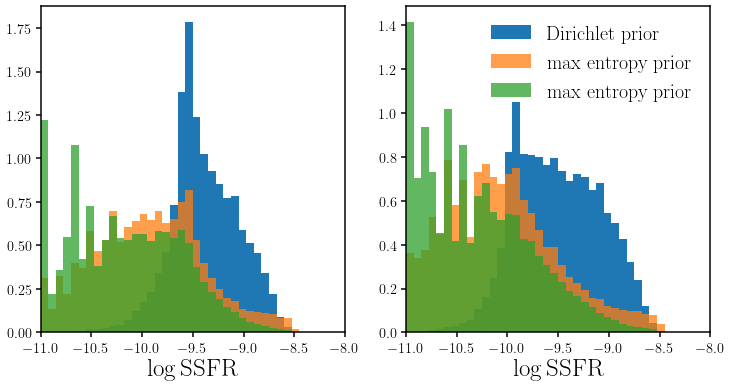

In [117]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.hist(logssfr_1gyr, range=[-11, -8], bins=40, density=True)
sub.hist(logssfr_1gyr, weights=w_kde_logssfr1gyr100myr, range=[-11, -8], bins=40,density=True, color='C1', alpha=0.75)
sub.hist(logssfr_1gyr, weights=w_gmm_logssfr1gyr100myr, range=[-11, -8], bins=40,density=True, color='C2', alpha=0.75)
sub.set_xlabel(r'$\log {\rm SSFR}$', fontsize=25)
sub.set_xlim(-11, -8)

sub = fig.add_subplot(122)
sub.hist(logssfr_100myr, range=[-11, -8], bins=40, density=True, label='Dirichlet prior')
sub.hist(logssfr_100myr, weights=w_kde_logssfr1gyr100myr, range=[-11, -8], bins=40,density=True, color='C1', alpha=0.75, label='max entropy prior')
sub.hist(logssfr_100myr, weights=w_gmm_logssfr1gyr100myr, range=[-11, -8], bins=40,density=True, color='C2', alpha=0.75, label='max entropy prior')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'$\log {\rm SSFR}$', fontsize=25)
sub.set_xlim(-11, -8)

Hmm, still not great...

# Applying maximum entropy priors to MC chains
For only the prior, maximum entropy correction using importance sampling weights successfully imposes uniformative priors on SSFR and log SSFR. Now lets apply it to actual MCMC chains and examine how the inferred parameters are altered

In [18]:
# read noiseless Lgal spectra of the spectral_challenge mocks 
specs, meta = Data.Spectra(sim='lgal', noise='bgs0', lib='bc03', sample='mini_mocha') 
# read Lgal photometry of the mini_mocha mocks 
photo, _ = Data.Photometry(sim='lgal', noise='legacy', lib='bc03', sample='mini_mocha')

In [19]:
# local directory where the MCMC files are stored
dir_mcmc = '/Users/ChangHoon/data/gqp_mc/mini_mocha/ispeculator/james/'

In [20]:
mcmcs = [] 
for i in range(10): 
    f = h5py.File(os.path.join(dir_mcmc, 'lgal.specphoto.noise_bgs0_legacy.emulator.%i.postproc.hdf5' % i), 'r')
    mcmc = {} 
    for k in f.keys(): 
        mcmc[k] = f[k][...]
    mcmcs.append(mcmc)

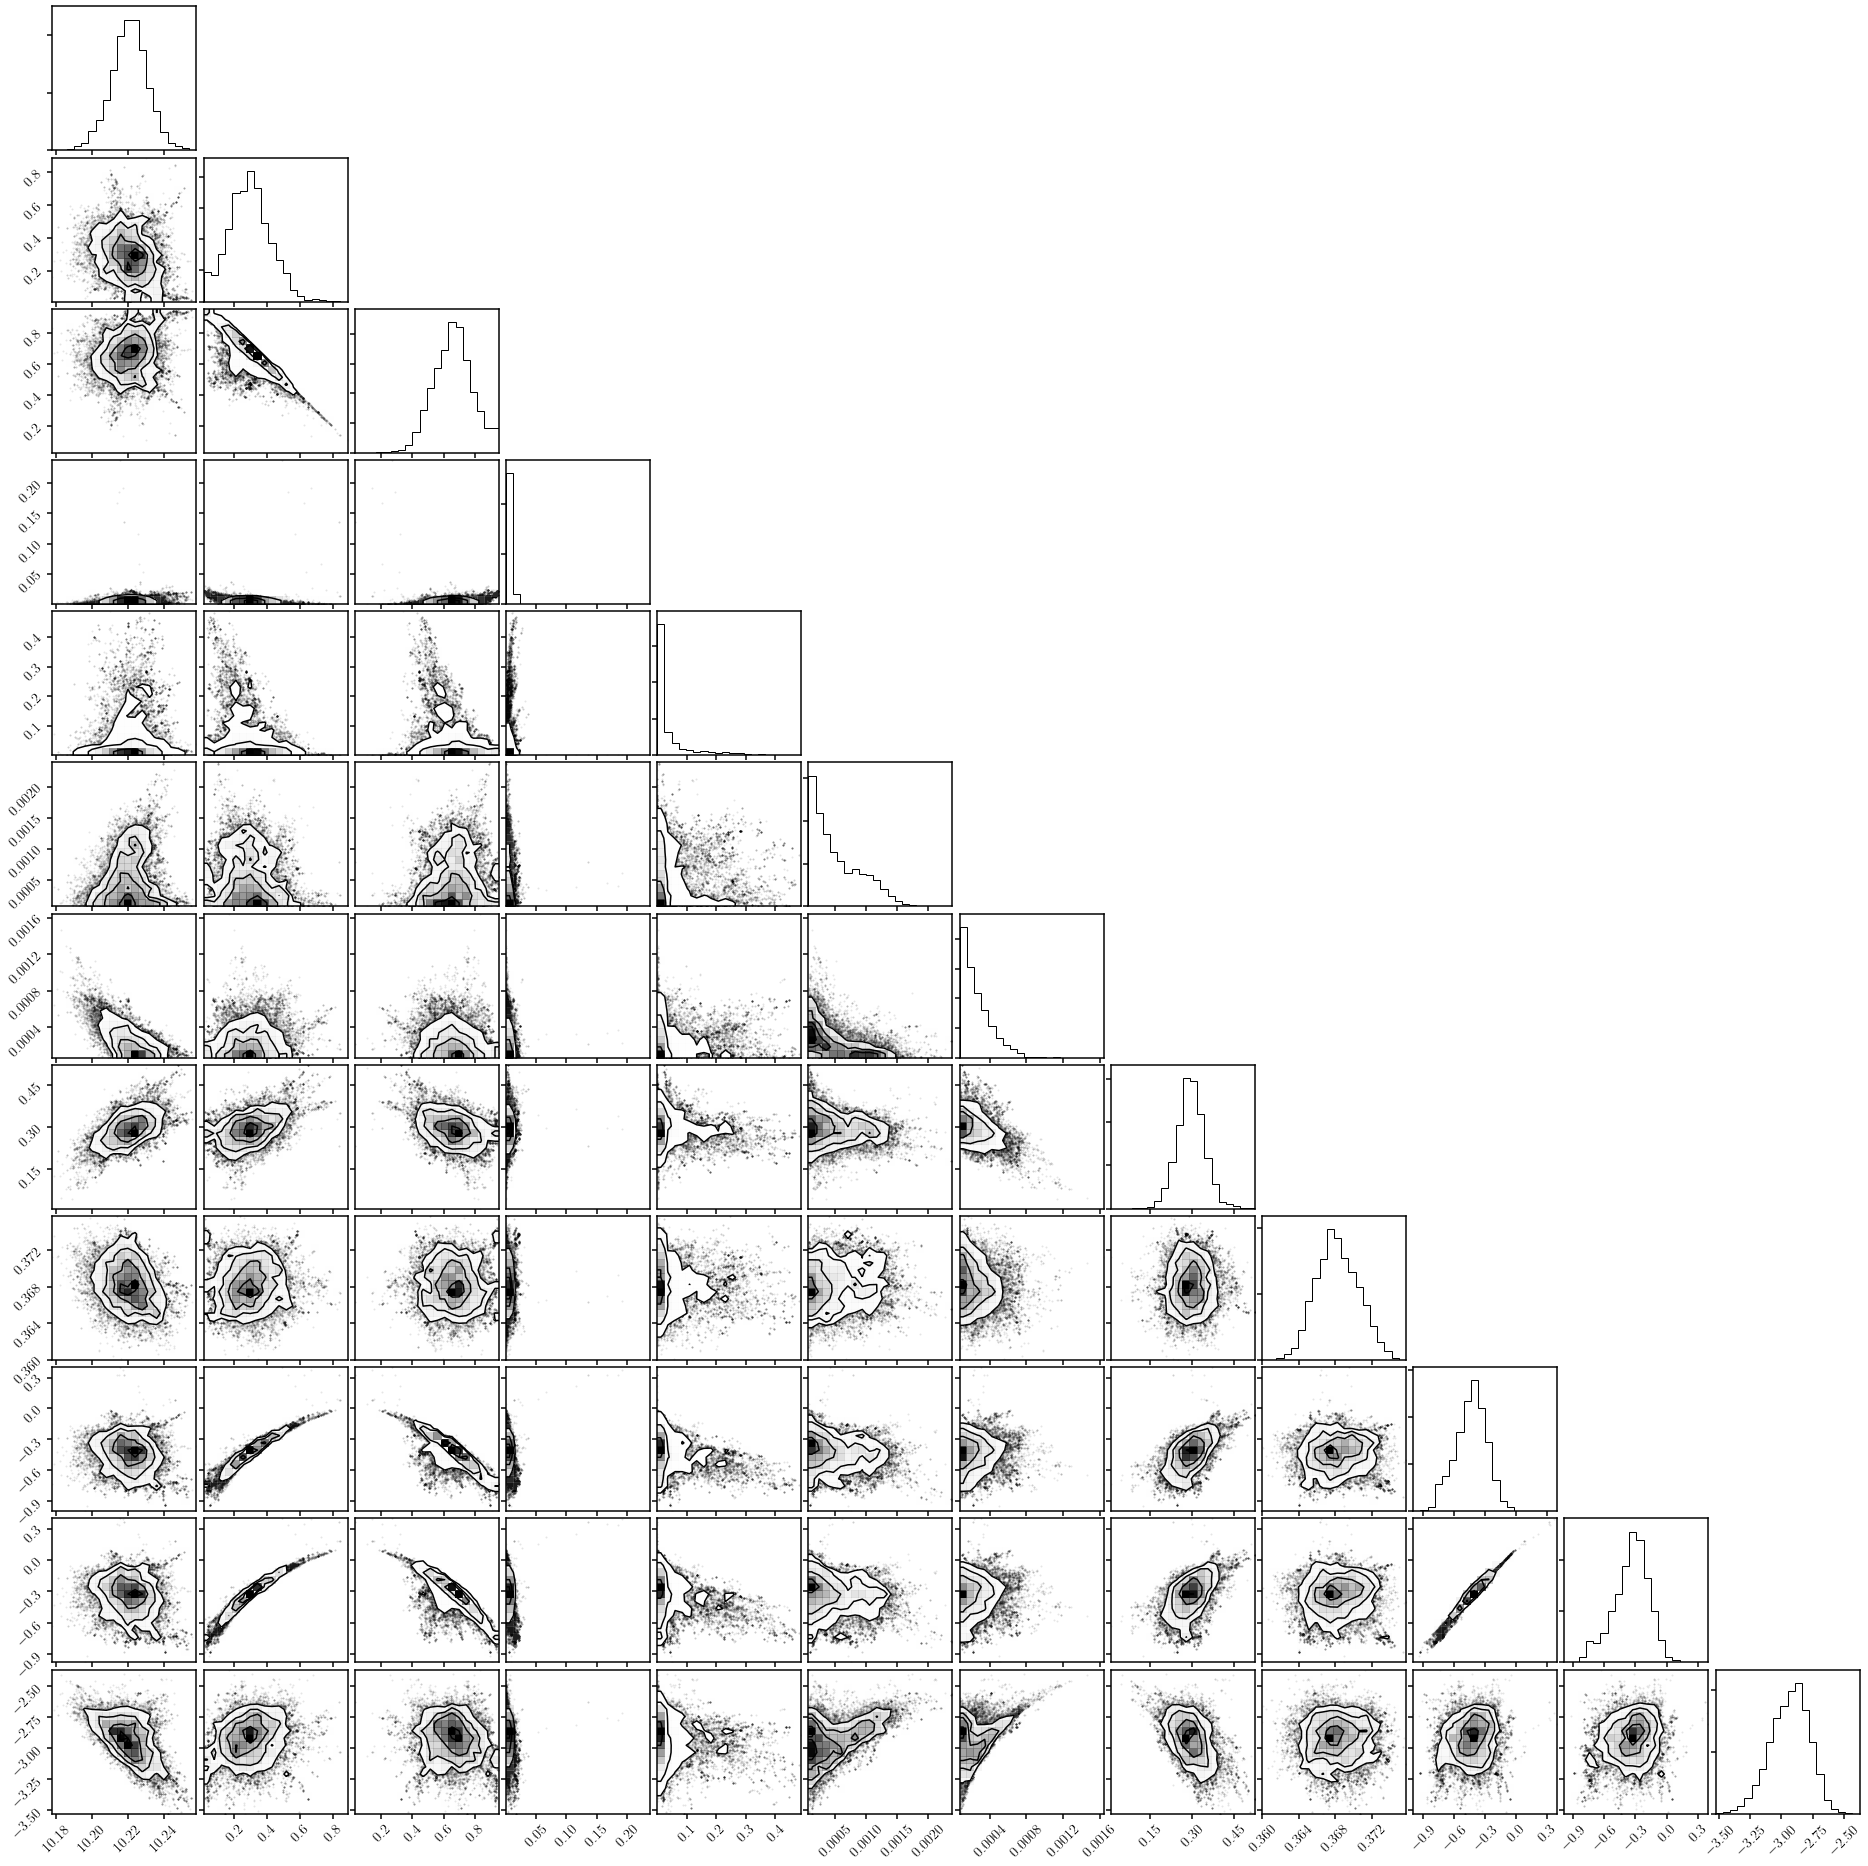

In [21]:
fig = DFM.corner(mcmcs[4]['mcmc_chain'][::100])

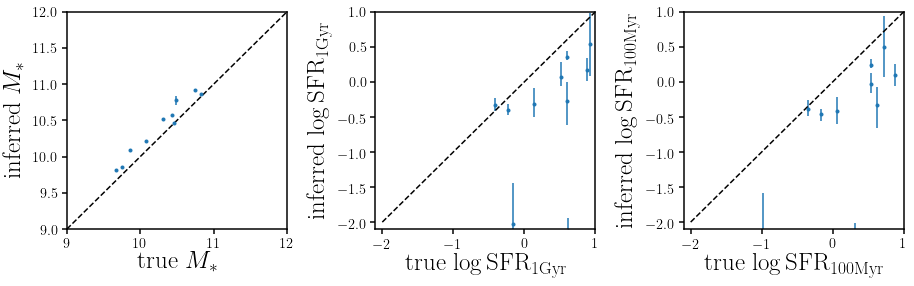

In [22]:
fig = plt.figure(figsize=(15,4))

# total M* comparison 
sub = fig.add_subplot(131)
sub.plot([9., 12.], [9., 12.], c='k', ls='--')
for i in range(10):
    sub.errorbar(meta['logM_total'][i], mcmcs[i]['theta_med'][0], 
                 yerr=[[mcmcs[i]['theta_1sig_plus'][0] - mcmcs[i]['theta_med'][0]], 
                       [mcmcs[i]['theta_med'][0] - mcmcs[i]['theta_1sig_minus'][0]]], 
                 fmt='.C0')
sub.set_xlabel('true $M_*$', fontsize=25)
sub.set_xlim(9., 12.)
sub.set_ylabel('inferred $M_*$', fontsize=25)
sub.set_ylim(9., 12.)

# log SFR 1gyr comparison
sub = fig.add_subplot(132)
sub.plot([-2., 1.], [-2., 1.], c='k', ls='--')
for i in range(10):
    sub.errorbar(np.log10(meta['sfr_1gyr'][i]), mcmcs[i]['theta_med'][10], 
                 yerr=[[mcmcs[i]['theta_1sig_plus'][10] - mcmcs[i]['theta_med'][10]], 
                       [mcmcs[i]['theta_med'][10] - mcmcs[i]['theta_1sig_minus'][10]]], 
                 fmt='.C0')
sub.set_xlabel(r'true $\log {\rm SFR}_{\rm 1Gyr}$', fontsize=25)
sub.set_xlim(-2.1, 1.)
sub.set_ylabel(r'inferred $\log {\rm SFR}_{\rm 1Gyr}$', fontsize=25)
sub.set_ylim(-2.1, 1.)

# log SFR 1gyr comparison
sub = fig.add_subplot(133)
sub.plot([-2., 1.], [-2., 1.], c='k', ls='--')
for i in range(10):
    sub.errorbar(np.log10(meta['sfr_100myr'][i]), mcmcs[i]['theta_med'][9], 
                 yerr=[[mcmcs[i]['theta_1sig_plus'][9] - mcmcs[i]['theta_med'][9]], 
                       [mcmcs[i]['theta_med'][9] - mcmcs[i]['theta_1sig_minus'][9]]], 
                 fmt='.C0')                
sub.set_xlabel(r'true $\log {\rm SFR}_{\rm 100Myr}$', fontsize=25)
sub.set_xlim(-2.1, 1.)
sub.set_ylabel(r'inferred $\log {\rm SFR}_{\rm 100Myr}$', fontsize=25)
sub.set_ylim(-2.1, 1.)

fig.subplots_adjust(wspace=0.4)

Now lets apply the maximum entropy prior correction importance weights so that we use a flat prior on SSFR

In [40]:
def w_maxent(_mcmc, dt=1., log=False): 
    '''calculate the maximum entropy prior correction importance sampling weights given mcmc chain
    '''
    # fit KDE to p(SSFR)
    _ssfr_prior = ispec.get_SFR(np.array([np.ones(len(b1)), b1, b2, b3, b4]), _mcmc['redshift'], dt=dt)
    if log: _ssfr_prior = np.log10(_ssfr_prior)
    else: _ssfr_prior *= 1e10
    
    # p(SSFR) KDE
    kde_ssfr_prior = gkde(_ssfr_prior)
    
    # p(SSFR(theta_chain))
    _b1, _b2, _b3, _b4 = _mcmc['mcmc_chain'][::100,1:5].T

    _ssfr = ispec.get_SFR(np.array([np.ones(len(_b1)), _b1, _b2, _b3, _b4]), _mcmc['redshift'], dt=dt)

    if log: _ssfr = np.log10(_ssfr)
    else: _ssfr *= 1e10
    
    return 1./kde_ssfr_prior.pdf(_ssfr)

In [41]:
ws_maxent_ssfr1gyr = [] 
ws_maxent_ssfr100myr = [] 
for i in range(10):
    ws_maxent_ssfr1gyr.append(w_maxent(mcmcs[i], dt=1., log=False))
    ws_maxent_ssfr100myr.append(w_maxent(mcmcs[i], dt=0.1, log=False))

In [42]:
def theta_importance_weighted(chain, weights): 
    '''apply importance sampling weights to mcmc chain and return median and +/- 1 sigma values
    '''
    lowlow_w, low_w, med_w, high_w, highhigh_w = [wq.quantile(chain, weights, qq) for qq in [0.025, 0.16, 0.50, 0.84, 0.975]]
    return med_w, low_w, high_w

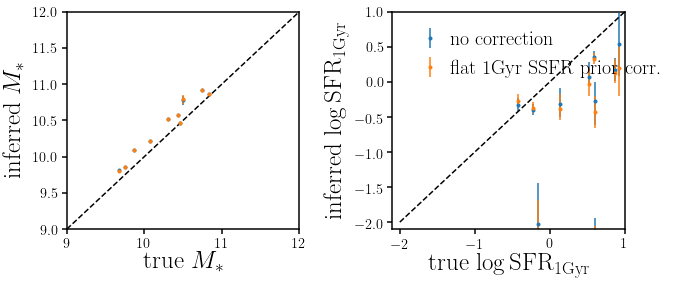

In [46]:
fig = plt.figure(figsize=(10,4))

# total M* comparison 
sub = fig.add_subplot(121)
sub.plot([9., 12.], [9., 12.], c='k', ls='--')
for i in range(10):
    sub.errorbar(meta['logM_total'][i], mcmcs[i]['theta_med'][0], 
                 yerr=[[mcmcs[i]['theta_1sig_plus'][0] - mcmcs[i]['theta_med'][0]], 
                       [mcmcs[i]['theta_med'][0] - mcmcs[i]['theta_1sig_minus'][0]]], 
                 fmt='.C0')
    
    tt_med, tt_low, tt_high = theta_importance_weighted(mcmcs[i]['mcmc_chain'].T[:,::100], ws_maxent_ssfr1gyr[i])
    sub.errorbar(meta['logM_total'][i], tt_med[0], yerr=[[tt_high[0] - tt_med[0]], [tt_med[0] - tt_low[0]]], fmt='.C1')
    
sub.set_xlabel('true $M_*$', fontsize=25)
sub.set_xlim(9., 12.)
sub.set_ylabel('inferred $M_*$', fontsize=25)
sub.set_ylim(9., 12.)

# log SFR 1gyr comparison
sub = fig.add_subplot(122)
sub.plot([-2., 1.], [-2., 1.], c='k', ls='--')
for i in range(10):
    sub.errorbar(np.log10(meta['sfr_1gyr'][i]), mcmcs[i]['theta_med'][10], 
                 yerr=[[mcmcs[i]['theta_1sig_plus'][10] - mcmcs[i]['theta_med'][10]], 
                       [mcmcs[i]['theta_med'][10] - mcmcs[i]['theta_1sig_minus'][10]]], 
                 fmt='.C0', label='no correction')
    
    tt_med, tt_low, tt_high = theta_importance_weighted(mcmcs[i]['mcmc_chain'].T[10,::100], ws_maxent_ssfr1gyr[i])
    sub.errorbar(np.log10(meta['sfr_1gyr'][i]), tt_med, yerr=[[tt_high - tt_med], [tt_med - tt_low]], 
                 fmt='.C1', label='flat 1Gyr SSFR prior corr.')
    if i == 0:
        sub.legend(loc='upper left', fontsize=20, handletextpad=0)
    
sub.set_xlabel(r'true $\log {\rm SFR}_{\rm 1Gyr}$', fontsize=25)
sub.set_xlim(-2.1, 1.)
sub.set_ylabel(r'inferred $\log {\rm SFR}_{\rm 1Gyr}$', fontsize=25)
sub.set_ylim(-2.1, 1.)

fig.subplots_adjust(wspace=0.4)

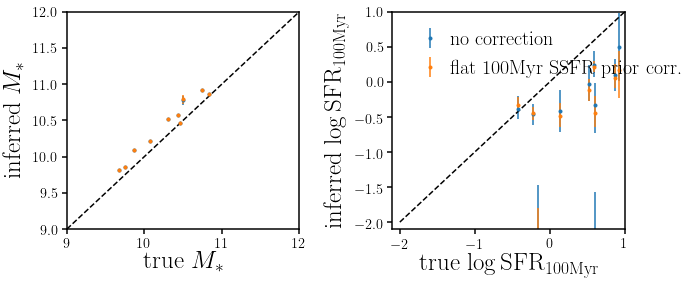

In [51]:
fig = plt.figure(figsize=(10,4))

# total M* comparison 
sub = fig.add_subplot(121)
sub.plot([9., 12.], [9., 12.], c='k', ls='--')
for i in range(10):
    sub.errorbar(meta['logM_total'][i], mcmcs[i]['theta_med'][0], 
                 yerr=[[mcmcs[i]['theta_1sig_plus'][0] - mcmcs[i]['theta_med'][0]], 
                       [mcmcs[i]['theta_med'][0] - mcmcs[i]['theta_1sig_minus'][0]]], 
                 fmt='.C0')
    
    tt_med, tt_low, tt_high = theta_importance_weighted(mcmcs[i]['mcmc_chain'].T[0,::100], ws_maxent_ssfr100myr[i])
    sub.errorbar(meta['logM_total'][i], tt_med, yerr=[[tt_high - tt_med], [tt_med - tt_low]], fmt='.C1')
    
sub.set_xlabel('true $M_*$', fontsize=25)
sub.set_xlim(9., 12.)
sub.set_ylabel('inferred $M_*$', fontsize=25)
sub.set_ylim(9., 12.)

# log SFR 1gyr comparison
sub = fig.add_subplot(122)
sub.plot([-2., 1.], [-2., 1.], c='k', ls='--')
for i in range(10):
    sub.errorbar(np.log10(meta['sfr_1gyr'][i]), mcmcs[i]['theta_med'][9], 
                 yerr=[[mcmcs[i]['theta_1sig_plus'][10] - mcmcs[i]['theta_med'][9]], 
                       [mcmcs[i]['theta_med'][10] - mcmcs[i]['theta_1sig_minus'][9]]], 
                 fmt='.C0', label='no correction')
    
    tt_med, tt_low, tt_high = theta_importance_weighted(mcmcs[i]['mcmc_chain'].T[9,::100], ws_maxent_ssfr1gyr[i])
    sub.errorbar(np.log10(meta['sfr_1gyr'][i]), tt_med, yerr=[[tt_high - tt_med], [tt_med - tt_low]], 
                 fmt='.C1', label='flat 100Myr SSFR prior corr.')
    if i == 0:
        sub.legend(loc='upper left', fontsize=20, handletextpad=0)
sub.set_xlabel(r'true $\log {\rm SFR}_{\rm 100Myr}$', fontsize=25)
sub.set_xlim(-2.1, 1.)
sub.set_ylabel(r'inferred $\log {\rm SFR}_{\rm 100Myr}$', fontsize=25)
sub.set_ylim(-2.1, 1.)

fig.subplots_adjust(wspace=0.4)

Overall, correction to a flat SSFR prior does not significantly impact the inferred $M_*$. However, the inferred SFRs are **significant** impacted. With the original Dirichlet priors, the SSFRs are significantly overestimated. 

Note that the true $\log {\rm SFR}$ in these figures do not mean much since the speculator model is inaccurate over this parameter space of SFH basis coefficients. Furthermore, we're using a simplified dust model.